In [ ]:
# !pip install adlfs
# !pip install ndpyramid
# !pip install pyresample
# !pip install xesmf

In [1]:
import adlfs
import xarray as xr
import odc.geo.xr
import pathlib
import zarr
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import ndpyramid
import coiled

In [ ]:
cluster = coiled.Cluster(idle_timeout="10 minutes",
                        n_workers=2, #30
                        worker_memory="512 GB", #32 
                        #worker_cpu=4, # 4,
                        #worker_options={"nthreads": 1},
                        #scheduler_memory="32 GB",
                        spot_policy="spot",
                        environ={"GDAL_DISABLE_READDIR_ON_OPEN": "EMPTY_DIR"},
                        workspace="uwtacolab",
                        )


client = cluster.get_client()

In [ ]:
client.restart()

In [2]:
sas_token = pathlib.Path('../sas_token.txt').read_text()

fs = adlfs.AzureBlobFileSystem(account_name="snowmelt", credential=sas_token)

mask_store = fs.get_mapper("snowmelt/snow_cover/global_modis_snow_cover.zarr")
output_store = fs.get_mapper("snowmelt/snow_cover/pyramid_global_modis_snow_cover.zarr")

In [3]:
seasonal_snow_mask_ds = xr.open_zarr(mask_store,
                                     decode_coords='all',
                                     consolidated=True,
                                     #mask_and_scale=False,
                                     #chunks={'water_year':1,"y":1200, "x":1200},
                                     )
seasonal_snow_mask_ds

<xarray.Dataset> Size: 448GB
Dimensions:               (water_year: 10, y: 43200, x: 86400)
Coordinates:
    spatial_ref           int64 8B ...
  * water_year            (water_year) int64 80B 2015 2016 2017 ... 2023 2024
  * x                     (x) float64 691kB -2.001e+07 -2.001e+07 ... 2.001e+07
  * y                     (y) float64 346kB 1.001e+07 1.001e+07 ... -1.001e+07
Data variables:
    SAD_DOWY              (water_year, y, x) float32 149GB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    SDD_DOWY              (water_year, y, x) float32 149GB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    max_consec_snow_days  (water_year, y, x) float32 149GB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
Attributes:
    processed_tiles:  ['h18_v17', 'h15_v16', 'h19_v17', 'h18_v16', 'h17_v17',...

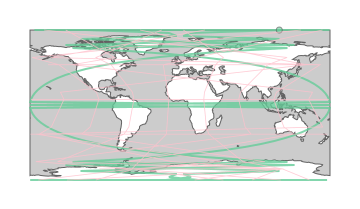

In [17]:
seasonal_snow_mask_ds.odc.geobox

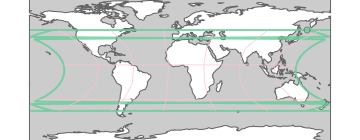

In [19]:
# use isel to select all but the first and last x and y coordinates
seasonal_snow_mask_ds.isel(x=slice(10000, -10000), y=slice(10000, -10000)).odc.geobox


In [11]:
seasonal_snow_mask_ds.isel(x=slice(10000, -10000), y=slice(10000, -10000)).odc.reproject(how="EPSG:3857",
                                     num_threads=16,
                                     )

GEOSException: TopologyException: side location conflict at -10.843524089278272 38.713463012852287. This can occur if the input geometry is invalid.

In [ ]:
client.restart()

In [ ]:
def reproject_and_write_to_zarr(ds, output_store, levels=4):
    """
    Reproject the dataset and write it to a Zarr store.
    """
    import rioxarray
    ds = ds.persist()
    reprojected_ds = ndpyramid.pyramid_reproject(ds, levels=levels)
    reprojected_ds.to_zarr(output_store, mode='w', consolidated=True)
    return reprojected_ds

# def reproject_and_write_to_zarr(ds, output_store, levels=4):
#     """
#     Reproject the dataset and write it to a Zarr store.
#     """
#     import odc.geo.xr
#     ds = ds.odc.reproject(how="EPSG:3857",
#                           num_threads=16,
#                           ) #  error: "GEOSException: TopologyException: side location conflict at..."
#     reprojected_ds = ndpyramid.pyramid_reproject(ds, levels=levels)
#     reprojected_ds.to_zarr(output_store, mode='w', consolidated=True)
#     return reprojected_ds

In [ ]:
future = client.submit(reproject_and_write_to_zarr, seasonal_snow_mask_ds, output_store, levels=4)

In [ ]:
future

In [ ]:
future.result()

In [ ]:
# download and compress zarr file
#lpath = "../snow_cover/global_modis_snow_cover.zarr"
#fs.download("snowmelt/snow_cover/global_modis_snow_cover.zarr", lpath, recursive=True)
#!tar --lzma -cvf global_modis_snow_cover.zarr.tar.lzma global_modis_snow_cover.zarr

In [ ]:
%%time
# using pyresample https://ndpyramid.readthedocs.io/en/latest/generated/ndpyramid.pyramid_resample.html https://ndpyramid.readthedocs.io/en/latest/examples/pyramid-resample.html https://github.com/carbonplan/ndpyramid/blob/main/ndpyramid/resample.py

levels = 2
resampled_pyramid = ndpyramid.pyramid_resample(seasonal_snow_mask_ds.rename({'water_year':'time'}), levels=levels,pixels_per_tile=512,x='x',y='y',resampling='nearest')

In [ ]:
resampled_pyramid

In [ ]:
resampled_pyramid['1'].ds['max_consec_snow_days']

In [ ]:
resampled_pyramid['1'].ds['max_consec_snow_days'].sel(time=2023).odc.explore(vmin=0,vmax=365)

In [ ]:
%%time
# https://github.com/carbonplan/ndpyramid/blob/main/docs/examples/pyramid-resample.ipynb
resampled_pyramid.to_zarr(output_store, consolidated=True, mode='w')

In [ ]:
# https://github.com/carbonplan/maps/blob/main/demo/pages/index.js